In [0]:
from google.colab import files
uploaded = files.upload()

Saving data_preparation.py to data_preparation.py


In [0]:
# To import the dependencies
import data_preparation as dp
import tensorflow as tf
import numpy as np
from scipy.special import softmax

In [0]:
# To remove the Graph Directory which store event files for tensorboard
rm -r Graph

rm: cannot remove 'Graph': No such file or directory


In [0]:
# To get the training and testing data from the data_preparation file
x_train,y_train,x_test,y_test = dp.train_test_split()

In [0]:
# Number of neurons in each hidden layer
BATCH_SIZE = 100
LEARNING_RATE = 0.01
TRAIN_STEPS = 140000
NUM_CLASSES = 7
CONV_1_CHANNELS = 500
CONV_2_CHANNELS = 100
FC_1_UNITS = 200
FC_2_UNITS = 84
FC_3_UNITS = 7

#Kernel Sizes
CONV_K_S = 5
POOL_K_S = 2

STRIDES = 2

In [0]:
#Reshape the dataset
x_train = x_train.reshape(x_train.shape[0],dp.P_S,dp.P_S,dp.BAND)
x_test = x_test.reshape(x_test.shape[0],dp.P_S,dp.P_S,dp.BAND)

# converting y_train and y_test into one hot form
y_train = tf.contrib.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.contrib.keras.utils.to_categorical(y_test,NUM_CLASSES)

W0720 16:38:11.389762 140121112250240 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.reset_default_graph()
sess = tf.Session()

In [0]:
# Define Inputs
with tf.name_scope('input'):
  patches = tf.placeholder(tf.float32,[None,dp.P_S,dp.P_S,dp.BAND], name = "patches")
  labels = tf.placeholder(tf.float32,[None,NUM_CLASSES], name = "labels")

In [0]:
#Define the model
with tf.name_scope("conv1"):
  conv1 = tf.keras.layers.Conv2D( filters = CONV_1_CHANNELS, kernel_size = [ CONV_K_S, CONV_K_S ], strides = STRIDES, padding = 'same', activation = 'relu', use_bias = True, bias_initializer=tf.constant_initializer(0.05), kernel_initializer='glorot_normal')(patches)
with tf.name_scope("pool1"):
  pool1 = tf.keras.layers.MaxPool2D( pool_size = (2,2), strides = STRIDES, padding = "same")(conv1)
with tf.name_scope("conv2"):
  conv2 = tf.keras.layers.Conv2D( filters = CONV_2_CHANNELS, kernel_size = [ CONV_K_S, CONV_K_S ], strides = STRIDES, padding = 'same', activation = 'relu', use_bias = True, bias_initializer=tf.constant_initializer(0.05), kernel_initializer='glorot_normal')(pool1)
with tf.name_scope("pool2"):
  pool2 = tf.keras.layers.MaxPool2D( pool_size = (2,2), strides = STRIDES, padding = "same")(conv2)
with tf.name_scope("Flatten"):
  flatten = tf.keras.layers.Flatten()(pool2)
with tf.name_scope("FC1"):
  fc_1 = tf.keras.layers.Dense(units = FC_1_UNITS, activation= 'relu', use_bias = True, kernel_initializer='glorot_normal', bias_initializer=tf.constant_initializer(0.05))(flatten)
with tf.name_scope("FC2"):
  fc_2 = tf.keras.layers.Dense(units = FC_2_UNITS, activation= 'relu', use_bias = True, kernel_initializer='glorot_normal', bias_initializer=tf.constant_initializer(0.05))(fc_1)
with tf.name_scope("FC3"):
  y = tf.keras.layers.Dense(units = FC_3_UNITS, activation= None, use_bias = True, kernel_initializer='glorot_normal', bias_initializer=tf.constant_initializer(0.05))(fc_2)
  


W0720 16:38:12.585485 140121112250240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Define Loss and optimizer
with tf.name_scope("loss"):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=labels))
  tf.summary.scalar('loss', loss)
with tf.name_scope("optimizer"):
  train = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(loss)

W0720 16:38:12.821815 140121112250240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
loss

<tf.Tensor 'loss/Mean:0' shape=() dtype=float32>

In [0]:
# Define evaluation
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [0]:
# Set up the TensorBoard
from tensorboardcolab import *
tbc=TensorBoardColab()

train_writer = tbc.get_deep_writers("train")
train_writer.add_graph(sess.graph)
test_writer = tbc.get_deep_writers("test")
test_writer.add_graph(sess.graph)

summary_op = tf.summary.merge_all()


Using TensorFlow backend.


Wait for 8 seconds...


W0712 10:37:47.747205 139972406392704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



TensorBoard link:
https://c02aa4f5.ngrok.io


In [0]:
sess.run(tf.global_variables_initializer())

In [0]:
# To extract next batch of size num 

BATCH_INDEX=0
IDX = None

def next_batch(num):
    #Return a total of `num` random samples and labels.
    global BATCH_INDEX
    global IDX
    if(BATCH_INDEX == 0):
      IDX = np.arange(0 , len(y_train))
      np.random.shuffle(IDX)
      
    batch = IDX[BATCH_INDEX:min(BATCH_INDEX+num,len(y_train))]
    data_shuffle = [x_train[ i] for i in batch]
    labels_shuffle = [y_train[ i] for i in batch]
    BATCH_INDEX = int((BATCH_INDEX+len(batch))%len(y_train))
    return np.array(data_shuffle),np.array(labels_shuffle)

In [0]:
for step in range(TRAIN_STEPS):
    batch_xs, batch_ys = next_batch(BATCH_SIZE) 
    summary_result, _ = sess.run([summary_op, train], feed_dict={patches: batch_xs, labels:batch_ys})

    train_writer.add_summary(summary_result, step)
    train_writer.add_run_metadata(tf.RunMetadata(), 'step%03d' % step)
    
    # calculate accuracy on the test set, every 100 steps.
    # we're using the entire test set here, so this will be a bit slow
    if step % 1000 == 0:
        summary_result, acc = sess.run([summary_op, accuracy], feed_dict={patches: x_test, labels: y_test})
        test_writer.add_summary(summary_result, step)
        test_writer.add_run_metadata(tf.RunMetadata(), 'step%03d' % step)
        print ("test accuracy: %f at step %d" % (acc, step))

print("Accuracy %f" % sess.run(accuracy, feed_dict={patches: x_test, labels: y_test}))

train_writer.close()
test_writer.close()

test accuracy: 0.031344 at step 0
test accuracy: 0.654980 at step 1000
test accuracy: 0.733689 at step 2000
test accuracy: 0.786859 at step 3000
test accuracy: 0.813327 at step 4000
test accuracy: 0.844671 at step 5000
test accuracy: 0.856745 at step 6000
test accuracy: 0.889714 at step 7000
test accuracy: 0.874855 at step 8000
test accuracy: 0.886232 at step 9000
test accuracy: 0.914790 at step 10000
test accuracy: 0.906199 at step 11000
test accuracy: 0.913861 at step 12000
test accuracy: 0.925935 at step 13000
test accuracy: 0.928256 at step 14000
test accuracy: 0.926399 at step 15000
test accuracy: 0.942652 at step 16000
test accuracy: 0.936615 at step 17000
test accuracy: 0.934293 at step 18000
test accuracy: 0.941491 at step 19000
test accuracy: 0.947063 at step 20000
test accuracy: 0.951474 at step 21000
test accuracy: 0.931507 at step 22000
test accuracy: 0.956814 at step 23000
test accuracy: 0.943348 at step 24000
test accuracy: 0.957511 at step 25000
test accuracy: 0.950313 a

In [0]:
y_hat = np.zeros((dp.HEIGHT,dp.WIDTH),dtype=int)

for i in range(dp.HEIGHT):
  for j in range(dp.WIDTH):
    patch = dp.patch_at_index(i,j)
    patch = patch.reshape(dp.P_S,dp.P_S,dp.BAND) 
    patch = np.array([patch])
    temp = sess.run(y,feed_dict={patches:patch})
    temp = softmax(temp)
    y_hat[i][j] = np.argmax(temp)+1

In [0]:
pip install  spectral

ImageView object:
  Interpolation       :  <default>

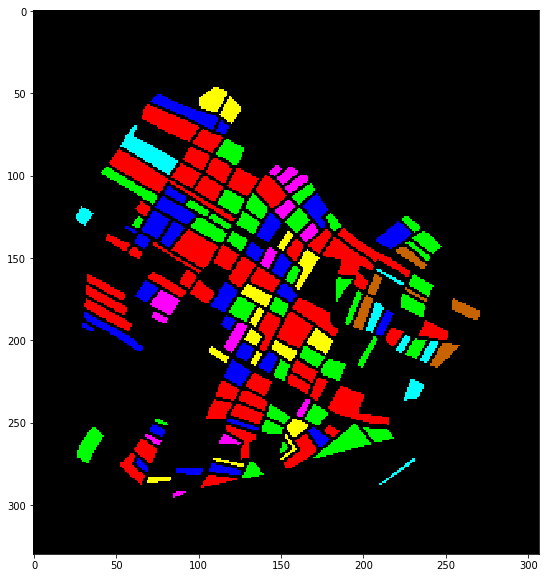

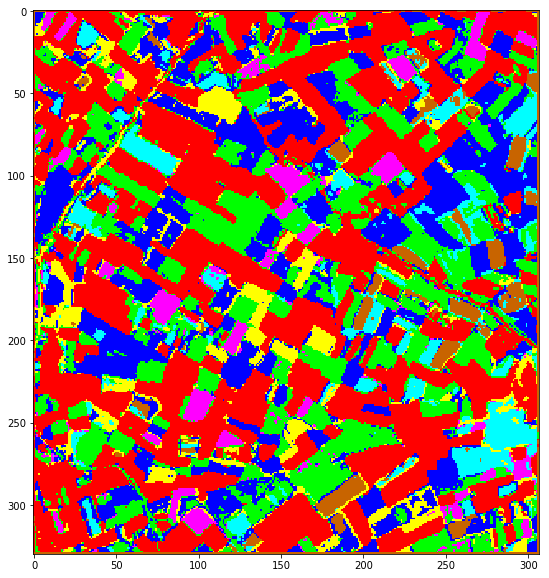

In [0]:
import spectral
spectral.imshow(classes = dp.mat_y,figsize=(10,10))
spectral.imshow(classes = y_hat,figsize=(10,10))